# Gradient Descent with More and Thuente Line Search method

In descent based optimization methods, one of the most important components is the step length or learning rate selection. If it is too small then the algorithm might take long time to converge. If it is too large, the algorithm will oscillate too much. Thus it is important to set step length such that there is substantial movement towards the minima but at the same time it is not too small. Mathematically, any step length satisfying these two conditions are said to satisfy Wolfe conditions, which are give as below:

i) Sufficient dcrease condition: $f(x+\alpha\phi(0))$

In [1]:
import numpy as np 
import pandas as pd
import math 
import operator
import random
import warnings
import matplotlib.pyplot as plt 
warnings.filterwarnings('ignore')
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats 
from sklearn.datasets.samples_generator import make_regression
import matplotlib.animation 
import matplotlib
import copy
import numpy.linalg as la
from scipy import finfo
_epsilon = math.sqrt(finfo(float).eps)

In [16]:
def cstep(stx,fx,dx,sty,fy,dy,stp,fp,dp,brackt,stpmin,stpmax):
    
    p66 = 0.66
    info = 0
    
    if ((brackt & (stp <= min(stx,sty) or stp >= max(stx,sty))) or dx*(stp-stx) >= 0.0 or stpmax < stpmin):
        return

    sgnd = dp*(dx/abs(dx))
    if (fp > fx):
        info = 1
        bound = 1
        theta = 3*(fx - fp)/(stp - stx) + dx + dp

        s = la.norm(np.array(np.hstack([theta,dx,dp])),np.inf)
        gamma = s*np.sqrt((theta/s)**2 - (dx/s)*(dp/s))
        if (stp < stx):
            gamma = -gamma
        
        p = (gamma - dx) + theta
        q = ((gamma - dx) + gamma) + dp
        r = p/q
        stpc = stx + r*(stp - stx);
        stpq = stx + ((dx/((fx-fp)/(stp-stx)+dx))/2)*(stp - stx)
        if (abs(stpc-stx).all() < abs(stpq-stx).all()):
            stpf = stpc;
        else:
            stpf = stpc + (stpq - stpc)/2 
        brackt = 1;
 
    elif sgnd.all() < 0.0:
        info = 2;
        bound = 0;
        theta = 3*(fx - fp)/(stp - stx) + dx + dp;
        s = la.norm(np.array(np.hstack([theta,dx,dp])),np.inf);
        gamma = s*np.sqrt((theta/s)**2 - (dx/s)*(dp/s));
        if (stp > stx):
            gamma = -gamma;
        p = (gamma - dp) + theta;
        q = ((gamma - dp) + gamma) + dx;
        r = p/q;
        stpc = stp + r*(stx - stp);
        stpq = stp + (dp/(dp-dx))*(stx - stp);
        if (abs(stpc-stp) > abs(stpq-stp)):
            stpf = stpc;
        else:
            stpf = stpq;
        brackt = 1;

    elif (abs(dp).all() < abs(dx).all()):
        info = 3;
        bound = 1;
        theta = 3*(fx - fp)/(stp - stx) + dx + dp;
        s = la.norm(np.array(np.hstack([theta,dx,dp])),np.inf);

        gamma = s*np.sqrt(max(0.,(theta/s)**2 - (dx/s)*(dp/s)));
        if (stp > stx):
            gamma = -gamma;
        
        p = (gamma - dp) + theta;
        q = (gamma + (dx - dp)) + gamma;
        r = p/q;
        if (r < 0.0 & gamma != 0.0):
            stpc = stp + r*(stx - stp);
        elif (stp > stx):
            stpc = stpmax;
        else:
            stpc = stpmin;
        stpq = stp + (dp/(dp-dx))*(stx - stp);
        if (brackt):
            if (abs(stp-stpc) < abs(stp-stpq)):
                stpf = stpc;
            else:
                stpf = stpq;
        else:
            if (abs(stp-stpc) > abs(stp-stpq)):
                stpf = stpc;
            else:
                stpf = stpq; 

    else:
        
        info = 4;
        bound = 0;
        if (brackt):
            theta = 3*(fp - fy)/(sty - stp) + dy + dp;
            s = la.norm(np.array(np.hstack([theta,dy,dp])),np.inf)
            gamma = s*np.sqrt((theta/s)**2 - (dy/s)*(dp/s));
            if (stp > sty):
                gamma = -gamma;
            p = (gamma - dp) + theta;
            q = ((gamma - dp) + gamma) + dy;
            r = p/q;
            stpc = stp + r*(sty - stp);
            stpf = stpc;
        elif (stp > stx):
            stpf = stpmax;
        else:
            stpf = stpmin;

    if(fp > fx):
        sty = stp;
        fy = fp;
        dy = dp;
    else:
        if (sgnd.all() < 0.0):
            sty = stx;
            fy = fx;
            dy = dx;
        stx = stp;
        fx = fp;
        dx = dp;

    stpf = min(stpmax,stpf.all());
    stpf = max(stpmin,stpf);
    stp = stpf;
    if (brackt & bound):
        if (sty > stx):
            stp = min(stx+p66*(sty-stx),stp);
        else:
            stp = max(stx+p66*(sty-stx),stp);
    
    return stx,fx,dx,sty,fy,dy,stp,fp,dp,brackt,info

def cvsrch(fcn,n,x,f,g,s,stp,ftol,gtol,xtol,stpmin,stpmax,maxfev):
    p5 = .5;
    p66 = .66;
    xtrapf = 4;
    info = 0;
    infoc = 1;

    if (n <= 0 or stp <= 0.0 or ftol < 0.0 or gtol < 0.0 or xtol < 0.0 or stpmin < 0.0 or stpmax < stpmin or maxfev <= 0):
        return
    
    dginit = g.dot(s);
    if (dginit >= 0.0): 
          return
    
    brackt = 0;
    stage1 = 1;
    nfev = 0;
    finit = f;
    dgtest = ftol*dginit;
    width = stpmax - stpmin;
    width1 = 2*width;
    wa = x;

    stx = 0.0;
    fx = finit;
    dgx = dginit;
    sty = 0.0;
    fy = finit;
    dgy = dginit;
    while True:
        
        if (brackt):
            stmin = min(stx,sty);
            stmax = max(stx,sty);
        else:
            stmin = stx;
            stmax = stp + xtrapf*(stp - stx); 

        if ((brackt & (stp <= stmin or stp >= stmax))or nfev >= maxfev-1 or infoc == 0 or (brackt and stmax-stmin <= xtol*stmax)):
            stp = stx;


        x = wa + stp * s;
        
        f,g = feval(x);
        nfev = nfev + 1;
        dg = g.dot(s);
        ftest1 = finit + stp*dgtest;
        
        if ((brackt & (stp <= stmin or stp >= stmax)) or infoc == 0):
            
            info = 6
         
        if (stp == stpmax and f <= ftest1 and dg <= dgtest):
            info = 5;
        
        if (stp == stpmin and (f > ftest1 or dg.all() >= dgtest)): 
            info = 4;
            
        if (nfev >= maxfev):
            info = 3;

        if (brackt and stmax-stmin <= xtol*stmax):
            info = 2;
            
        if (f <= ftest1 and abs(dg) <= gtol*(-dginit)):
            info = 1;
        
        if (info != 0):
            return x,f,g,stp,info,nfev
        
        if (stage1 and f <= ftest1 and dg >= min(ftol,gtol)*dginit):
            stage1 = 0;
          
        if (stage1 and f <= fx and f > ftest1):

            fm = f - stp*dgtest;
            fxm = fx - stx*dgtest;
            fym = fy - sty*dgtest;
            dgm = dg - dgtest;
            dgxm = dgx - dgtest;
            dgym = dgy - dgtest;
            
            stx,fxm,dgxm,sty,fym,dgym,stp,fm,dgm,brackt,infoc = cstep(stx,fxm,dgxm,sty,fym,dgym,stp,fm,dgm,brackt,stmin,stmax);
        
            fx = fxm + stx*dgtest;
            fy = fym + sty*dgtest;
            dgx = dgxm + dgtest;
            dgy = dgym + dgtest;
        else:
            stx,fx,dgx,sty,fy,dgy,stp,f,dg,brackt,infoc= cstep(stx,fx,dgx,sty,fy,dgy,stp,f,dg,brackt,stmin,stmax);
            
        if (brackt): 
            if (abs(sty-stx) >= p66*width1) :
                stp = stx + p5*(sty - stx);
            width1 = width;
            width = abs(sty-stx);
    return  x,f,g,stp,info,nfev

def feval(x):
    return 100*(x[1]-x[0]**2)**2+(1-x[0])**2,np.array([-400*x[0]*(x[1]-x[0]**2)-2*(1-x[0]),200*x[0]*(x[1]-x[0]**2)])

def gd():
    cost=[]
    position=[]
    history=[]
    x_p=[-1.2,1]
    position.append(x_p.copy())
    x_pthis=copy.copy(x_p)
    history.append(x_pthis)
    f,g=feval(x_p)
    i=0
    cost_this=f
    cost.append(cost_this)
    while cost_this>1e-05:
        i+=1
        step=1
        x_p,f,g,stp,info,nfev=cvsrch(feval,2,x_p,f,g,-g,step,ftol=_epsilon,gtol=_epsilon,xtol=_epsilon,stpmin=0,stpmax=1,maxfev=100)
        position.append(x_p.copy())
        cost_prev=cost_this
        cost_this=f
        cost.append(cost_this)
        
    return x_p,cost,history,i,position

In [17]:
a,b,c,d,pos=gd()

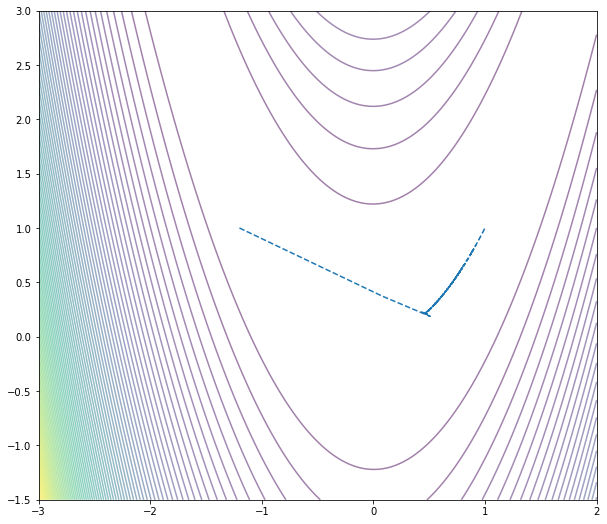

In [8]:
%matplotlib inline
pos1=np.vstack(pos)
x = pos1[:,0]
y = pos1[:,1]
def func_plot(x):
    return 100*(x[1]-x[0]**2)**2+(1-x[0])**2
xx=np.linspace(-3,2,1000) 
yy=np.linspace(-1.5,3,1000) 
xx_, yy_ = np.meshgrid(xx,yy)
f=func_plot([xx_,yy_])
fig = plt.figure(figsize=(10,9))
levels = np.logspace(0.3, 3.5, 15)
plt.plot(x,y,'--')
plt.contour(xx_, yy_, f,100, color='b', alpha=0.5, offset=0, stride=30,cmap="viridis")

In [ ]:
def BFGS():
    
    cost=[]
    history=[]
    position=[]
    x_p=np.matrix(x.copy())
    position.append(x_p.tolist().copy())
    x_pthis=x_p.copy()
    history.append(x_pthis)
    cost_init=func(x_p)
    i=0
    cost_this=cost_init
    cost.append(cost_this)
    cost_prev= math.inf
    hess_inv=np.eye(2)
    
    while i<=50:#cost_this>1e-2:
        
        i+=1
        x_delta=dfunc(x_p) 

        p=(-1*hess_inv*x_delta.T).T  # Search direction
        alpha=0.0001
        beta=0.9
        step=line_search(x_p,p,alpha,beta)  #step search
        grad_k=dfunc(x_p)
        x_p=x_p+step*p
        sk=(step*p).T
        grad_k_1=dfunc(x_p)
        yk=(grad_k_1-grad_k).T
        rhok=1/(yk.T*sk)
        hess_inv=(np.eye(2)-float(rhok)*sk*yk.T)*hess_inv*(np.eye(2)-float(rhok)*yk*sk.T)+float(rhok)*sk*sk.T
        
        position.append(x_p.tolist().copy())
        cost_prev=cost_this
        cost_this=func(x_p)
        cost.append(cost_this)
        x_pthis=copy.copy(x_p)
        history.append(x_pthis)
        
    return x_p,cost,history,i,position
